# SQL Programmeringsuppgift Matilda Wilhelmsson

# Installera metoder och libraries
Vi börjar med att se till att vi har alla instrument vi behöver för våra
uträkningar och visualiseringar.

In [49]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats

In [50]:
!pip install sqlalchemy
!pip install pyodbc

from sqlalchemy import create_engine, Table, inspect
import pandas as pd

def new_engine(dialect, server, database, user=None, password=None, integrated_security=True):
    if integrated_security:
         eng = f"{dialect}://{server}/{database}?trusted_connection=yes&driver=ODBC+Driver+17+for+SQL+Server"
            
    else:
         eng = f"{dialect}://{user}:{password}@{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server"
    print(eng)
    return create_engine(eng)

engine = new_engine('mssql', 'MSI', 'AdventureWorks2022', integrated_security=True)

print(type(engine))

connection = engine.connect()

mssql://MSI/AdventureWorks2022?trusted_connection=yes&driver=ODBC+Driver+17+for+SQL+Server
<class 'sqlalchemy.engine.base.Engine'>


# AdventureWorks2022: Deskriptiv sammanfattning
Här tar vi fram den viktigaste deskriptiva statistiken för
vårt företag AdventureWorks. Vi tittar bla på populära varor, antal anställda, sales(year),
geografisk spridning, samt företagets expansion.

In [51]:
# Vi börjar med företagets ledning.
# När vi kör nedanstående query får vi fram de anställda med 
# de 10 första ID numren i företaget.
# Först i listan får vi upp företagets CEO Ken Sanchéz.

TopEmployee = """SELECT TOP (5) e.BusinessEntityID,
	p.FirstName,
	p.LastName,
	e.JobTitle,
	e.HireDate
FROM HumanResources.Employee AS e INNER JOIN Person.Person as p
	ON e.BusinessEntityID = p.BusinessEntityID
ORDER BY e.BusinessEntityID;
"""

pd.read_sql(sql=TopEmployee, con=connection)

,BusinessEntityID,FirstName,LastName,JobTitle,HireDate
0,1,Ken,Sánchez,Chief Executive Officer,2009-01-14
1,2,Terri,Duffy,Vice President of Engineering,2008-01-31
2,3,Roberto,Tamburello,Engineering Manager,2007-11-11
3,4,Rob,Walters,Senior Tool Designer,2007-12-05
4,5,Gail,Erickson,Design Engineer,2008-01-06


In [52]:
# Näst kollar vi på vad företaget säljer mest av.
# Vi kan se att de bäst säljande produkterna är
# kläder, vattenflaskor och hjälmar. 
# Företaget inriktar sig på sportprodukter.

TopProducts = """SELECT TOP (10) 
	p.Name,
	SUM(sod.OrderQty) AS TotalSold
FROM Production.Product AS p INNER JOIN Sales.SalesOrderDetail AS sod
ON p.ProductID = sod.ProductID
GROUP BY p.ProductID, p.Name
ORDER BY SUM(sod.OrderQty) DESC;
"""

pd.read_sql(sql=TopProducts, con=connection)

,Name,TotalSold
0,AWC Logo Cap,8311
1,Water Bottle - 30 oz.,6815
2,"Sport-100 Helmet, Blue",6743
3,"Long-Sleeve Logo Jersey, L",6592
4,"Sport-100 Helmet, Black",6532
5,"Sport-100 Helmet, Red",6266
6,"Classic Vest, S",4247
7,Patch Kit/8 Patches,3865
8,"Short-Sleeve Classic Jersey, XL",3864
9,"Long-Sleeve Logo Jersey, M",3636


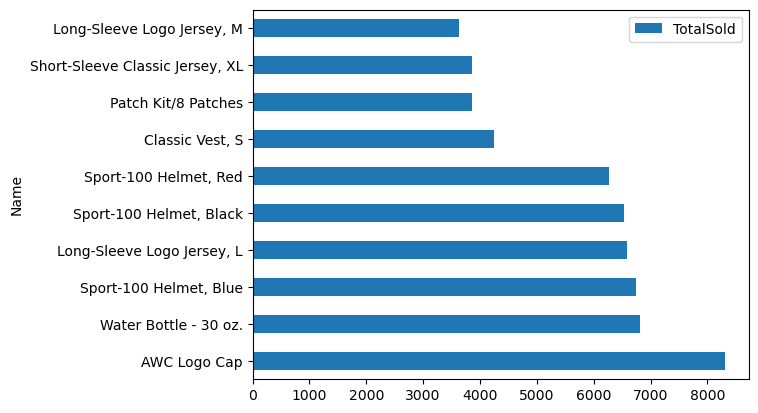

In [53]:
df = pd.read_sql(sql=TopProducts, con=connection)

df.plot.barh(x='Name', y='TotalSold')
plt.show()

In [54]:
# Nu vore det spännande att kolla på hur mycket företaget har 
# sålt för årligen sedan företaget grundades.
# Vi får fram följande resultat:
# 2011: 12,641,672.212954 USD
# 2012: 33,524,301.324434 USD
# 2013: 43,622,479.051635 USD
# 2014: 20,057,928.810865 USD.

YearlySales = """SELECT YEAR(soh.OrderDate) AS YEAR,
	SUM(sod.LineTotal) AS TotalYearlySales
FROM Sales.SalesOrderDetail AS sod 
INNER JOIN Sales.SalesOrderHeader AS soh
ON sod.SalesOrderID = soh.SalesOrderID
GROUP BY YEAR(soh.OrderDate)
ORDER BY YEAR(soh.OrderDate);
"""

pd.read_sql(sql=YearlySales, con=connection)


,YEAR,TotalYearlySales
0,2011,1.264167e+07
1,2012,3.352430e+07
2,2013,4.362248e+07
3,2014,2.005793e+07


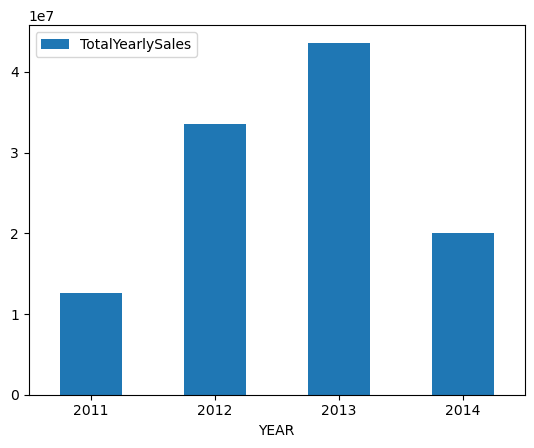

In [55]:
df = pd.read_sql(sql=YearlySales, con=connection)

df.plot.bar(x='YEAR', y='TotalYearlySales', rot=0)
plt.show()

In [56]:
# Här måste jag kolla hur jag kan få sales för varje enskild månad uppdelat
# eftersom åren 2011 och 2014 inte innehåller sales för varje månad.


MonthlySales = """SELECT YEAR(soh.OrderDate) AS YEAR,
MONTH(soh.OrderDate) AS MONTH,
FORMAT(soh.OrderDate, 'yy MMM') AS YearMonth,
	SUM(sod.LineTotal) AS TotalMonthlySales
FROM Sales.SalesOrderDetail AS sod 
INNER JOIN Sales.SalesOrderHeader AS soh
ON sod.SalesOrderID = soh.SalesOrderID
GROUP BY MONTH(soh.OrderDate), YEAR(soh.OrderDate),FORMAT(soh.OrderDate, 'yy MMM')
ORDER BY YEAR(soh.OrderDate), MONTH(soh.OrderDate) ;
"""

pd.read_sql(sql=MonthlySales, con=connection)

,YEAR,MONTH,YearMonth,TotalMonthlySales
0,2011,5,11 May,5.038059e+05
1,2011,6,11 Jun,4.589108e+05
2,2011,7,11 Jul,2.044600e+06
3,2011,8,11 Aug,2.495817e+06
4,2011,9,11 Sep,5.020738e+05
5,2011,10,11 Oct,4.588762e+06
6,2011,11,11 Nov,7.378398e+05
7,2011,12,11 Dec,1.309863e+06
8,2012,1,12 Jan,3.970627e+06
9,2012,2,12 Feb,1.475427e+06


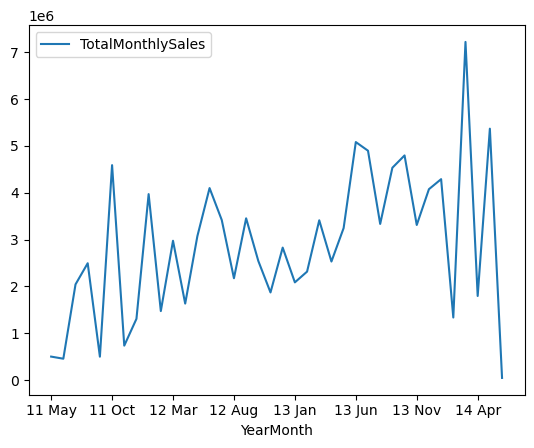

In [57]:
df = pd.read_sql(sql=MonthlySales, con=connection)

df.plot.line(x='YearMonth', y='TotalMonthlySales')

plt.show()

In [58]:
# Hur många anställda har företaget?
# SVAR: Företaget har totalt 290 anställda.

TotalEmployees = """SELECT COUNT(BusinessEntityID) AS NumberOfEmployees
FROM HumanResources.Employee;
"""
pd.read_sql(sql=TotalEmployees, con=connection)

,NumberOfEmployees
0,290


In [62]:
# Varav 206 är män och 84 är kvinnor.

EmployeesByGender = """SELECT Gender,
	COUNT(BusinessEntityID) AS NumberOfEmployees
FROM HumanResources.Employee
GROUP BY Gender;
"""
pd.read_sql(sql=EmployeesByGender, con=connection)

,Gender,NumberOfEmployees
0,F,84
1,M,206


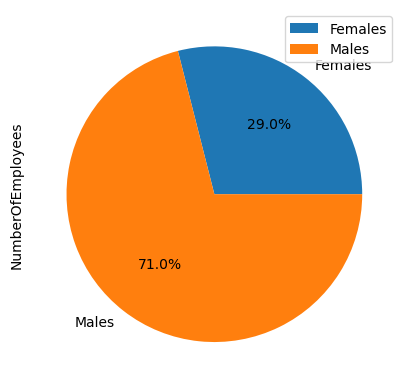

In [66]:
df = pd.read_sql(sql=EmployeesByGender, con=connection)
labels = 'Females', 'Males'

df.plot.pie(y='NumberOfEmployees', labels=labels, autopct='%1.1f%%') #haha vad gör jag här med labels?
plt.show()

# AdventureWorks2022: Statistisk analys

In [11]:
# Här tar vi fram totalt antal sålda varor (707,708,711) för samtliga år vi har data.

YearlyQtySold = """SELECT YEAR(soh.OrderDate) AS YEAR,
	SUM(sod.OrderQty) AS TotalQtySold
FROM Sales.SalesOrderDetail AS sod 
INNER JOIN Sales.SalesOrderHeader AS soh
ON sod.SalesOrderID = soh.SalesOrderID
WHERE ProductID = 707 or ProductID = 708 or ProductID = 711
GROUP BY YEAR(soh.OrderDate)
ORDER BY YEAR(soh.OrderDate);
"""

pd.read_sql(sql=YearlyQtySold, con=connection)

,YEAR,TotalQtySold
0,2011,1032
1,2012,4184
2,2013,9116
3,2014,5209


In [12]:
# Här tar vi fram totalt antal sålda varor (707,708,711) under reaperioden 2012.

SaleQtySold12 = """SELECT SUM(sod.OrderQty) AS QtySale12
FROM Sales.SalesOrderDetail AS sod 
INNER JOIN Sales.SalesOrderHeader AS soh
ON sod.SalesOrderID = soh.SalesOrderID
WHERE (ProductID = 707 or ProductID = 708 or ProductID = 711)
	AND (OrderDate > '2012-05-29' AND OrderDate < '2012-06-29')
GROUP BY soh.OrderDate;
"""

pd.read_sql(sql=SaleQtySold12, con=connection)

,QtySale12
0,492


In [13]:
# Här tar vi fram totalt antal sålda varor (707,708,711) under reaperioden 2013.

SaleQtySold13 = """SELECT SUM(sod.OrderQty) AS QtySale13
FROM Sales.SalesOrderDetail AS sod 
INNER JOIN Sales.SalesOrderHeader AS soh
ON sod.SalesOrderID = soh.SalesOrderID
WHERE (ProductID = 707 or ProductID = 708 or ProductID = 711)
	AND (OrderDate > '2013-05-29' AND OrderDate < '2013-06-29');
"""

pd.read_sql(sql=SaleQtySold13, con=connection)

,QtySale13
0,815


In [ ]:
# Nu ska vi skapa konfidensintervall
# Konfidensintervall skillnad mellan andelar två stickprov.
# Vi vill pröva hypotesen om en ökning från 10-15% rea (2012-2013),
# påverkar andelen försäljning under året som sker under reaperioden.
# Rimligtvis borde försäljningen öka om rean ökar.
# Om försäljningen inte ökar så finns ju ingen anledning att öka rean.
# Vi kollar andelar istället för antal sålda varor,
# eftersom att företaget sålde långt fler varor under 2013,
# då företaget var i en expansionsfas.

In [14]:
# För att kunna använda ett konfidensintervall behöver vi
# först räkna ut andelen av årets försäljning som skedde under 
# reaperioden. Vi gör detta för både 2012 och 2013.

#Reaperiod 2012, andel av årets sales.
print(f"Andelen sålda varor under reaperioden 2012 var: {round((492/4184), 3)} procent")
print()
print(f"Andelen sålda varor under reaperioden 2013 var: {round((815/9116), 3)} procent")

Andelen sålda varor under reaperioden 2012 var: 0.118 procent

Andelen sålda varor under reaperioden 2013 var: 0.089 procent


In [15]:
# Här lägger vi in våra variabler. Andel p och stickprovsstorleken n.

p1, n1 = 0.118, 4184  # proportion and sample size for group 1
p2, n2 = 0.089, 9116  # proportion and sample size for group 2
 
# Calculate the standard error
se = np.sqrt(p1 * (1 - p1) / n1 + p2 * (1 - p2) / n2)
 
# Choose a confidence level
confidence_level = 0.95
z_critical = 1.96   #Vi väljer värdet 1.96 då detta leder till ett 95-procentigt kfi.
 
# Calculate the margin of error
margin_error = z_critical * se
 
# Calculate the confidence interval
ci_lower = (p1 - p2) - margin_error
ci_upper = (p1 - p2) + margin_error
 
print("Konfidensintervall:", (ci_lower, ci_upper))

Konfidensintervall: (0.017610240635259976, 0.04038975936474002)
